# Workshop: Unseen Species Modelling Applied to Medieval Literature

Teachers: Elisabeth de Bruijn, Mike Kestemont, and Katarzyna Anna Kapitan

Date: 10 June 2025

Place: École nationale des chartes, Paris

## Introduction

This workshop provides a hands-on introduction to Copia (https://copia.readthedocs.io/en/latest/intro.html), a statistical package for estimating the diversity and richness of taxa (species, works, categories of objects) on the basis of abundance data. The package was developed by Mike Kestemont and Folgert Karsdorp and has been used in studying, among other things, the loss of medieval chivalric and heroic literature (Kestemont et al. 2022, https://gwern.net/doc/statistics/survival-analysis/2022-kestemont.pdf).


For our workshop today we will use the case study of medieval heroic and chivalric texts to introduce participants to this approach.

The goals of the workshop are to teach participants how to:
- prepare data for analysis,
- conduct the analysis with Copia,
- visualise and interpret the results.
- apply the methodology to different datasets.


If you take inspiration from this work, please cite the paper (https://www.science.org/doi/10.1126/science.abl7655) and its supplementary materials (https://www.science.org/action/downloadSupplement?doi=10.1126%2Fscience.abl7655&file=science.abl7655_sm.pdf).



__Let's start by installing the package:__

In [ ]:
# Uncomment the line below if running for the first time in Colab.
!pip install git+https://github.com/mikekestemont/copia.git

  Cloning https://github.com/mikekestemont/copia.git to /tmp/pip-req-build-9vh_dzvl
  Running command git clone --filter=blob:none --quiet https://github.com/mikekestemont/copia.git /tmp/pip-req-build-9vh_dzvl
  Resolved https://github.com/mikekestemont/copia.git to commit 766c7d96cebcaab33589dc6eae1ef7f7eb6dd101
  Preparing metadata (setup.py) ... done
  Created wheel for copia: filename=copia-0.1.5-py3-none-any.whl size=29130 sha256=47d4bca99ed119d2d3282775f04ee1b646d700565ef172bc996ca79e21ef4059
  Stored in directory: /tmp/pip-ephem-wheel-cache-n14vy7su/wheels/a6/73/a7/81a5bac3fb125a222df9ae91dd711d51dcd11d0bb9802575c8
Successfully built copia


*You might need to restart the kernel to continue*

# 1. Data Preprocessing

*This section is a revised copy of the tutorial: https://copia.readthedocs.io/en/latest/data.html*

To evaluate species richness, two primary data types can be used: individual-based abundance data and sample-based incidence data. In our workshop we will focus on individual-based abundance data, represented by the `AbundanceData` object in `Copia`.

This data representation disregards sampling units and records the total count for each species (across all sampling units).

Regardless of how you collected your data, in order to conduct data analysis with `Copia`, we need to format our data as `AbundanceData`.

To facilitate this, the `copia.data.to_copia_dataset()` function is designed to convert a collection of observations into a structured `Copia` dataset.

Let's imagine we are on a biodiversity campaign in Paris and your task is to note down all the species you saw and how many times you saw them.

You will probably see one or two dogs, the same for cats, and plenty of rats and pigeons. Let's say:
- dog       1
- cat       2
- pigeon    4
- rat       5

In the code call bellow you see how to store our observations as `Pandas` `dataFrame`, and then use the `copia.data.to_copia_dataset()` function to convert it into `AbundanceData`.

In [ ]:
from copia.data import to_copia_dataset
import pandas as pd
import numpy as np

counts = pd.Series([1, 2, 4, 5], index=["dog", "cat", "pigeon", "rat"])
print("Our counts:\n", counts)

ds = to_copia_dataset(counts, data_type="abundance", input_type="counts")
print("Abundance Data:\n", ds)

Our counts:
 dog       1
cat       2
pigeon    4
rat       5
dtype: int64
Abundance Data:
 AbundanceData(S_obs=4, f1=1, f2=1, n=np.int64(12), counts=array([1, 2, 4, 5]))


As you can see in the output of the call above, AbundanceData contains information about the total number of sightings ($n$), the total number of species observed($S_{obs}$), as well as how many of them were observed only once ($f_1$) and twice ($f_2$).

- We saw four species in total: $S_{obs}$ = 4

- We saw one species once (dog): $f_1$ = 1

- We saw one species twice (cat): $f_2$ = 1

- And we had a total of 12 sightings of all species (1 + 2 + 4 + 5 = 12), so $n$ = 12


You can access each of these values individually in the following way:

In [ ]:
print(ds.S_obs)
print(ds.n)
print(ds.f1)
print(ds.f2)

4
12
1
1


Why do we care about $f_1$ (singletons) and $f_2$ (doubletons), but not other counts?

Because the Chao1 estimator formula that we will use in our experiments today requires information about two primary kinds of observations: the number of species observed only once (singletons, $f_1$) and the number of species observed twice (doubletons, $f_2$). These two quantities are crucial for estimating the unseen diversity in our dataset -- in other words -- estimating the number of species we didn't observe at all ($f_0$).  

In the case of Paris, urban legend has it that there are squirrels in the city, but you barely ever see them. There are certainly other species that exist but are rarely observed. We want to estimate how many other species are like squirrels -- they exist, but we didn't see them.

## 1.2 From Spreadsheets to AbundanceData

Above, you saw how to manually create a DataFrame with your observations and then convert it into `AbundanceData`.

You don't want to do it by hand, do you?

So now let's learn how to load externally stored data about our observations and convert it into AbundanceData. Let's assume we have collected and stored information about your observations in a spreadsheet or a CSV file, where you record different species and their sightings.

For the purpose of our workshop, let's leave the fauna of Paris behind and focus on medieval literature. Today, we will be counting titles of medieval literary works and the documents in which they are still extant. So, we will be registering the titles of the works you're interested in and the sigla of the witnesses, or the shelfmarks of the manuscripts preserving these works.

We've prepared a dataset for you using the Icelandic dataset from our "Forgotten Books" paper.

You can find the file here, if you want to give it a look: https://www.dropbox.com/scl/fi/483gj8lacxrj3u6y2papp/dum.csv?rlkey=1hueny19gcufpcdoo1b5pgb1a&st=5v716t3l&dl=0


If you open it in Excel, you'll see that it can be represented as a simple spreadsheet where rows are individual sightings and columns record information about the names of the species (i.e. the titles of our medieval works) and where we saw them (i.e. the signatures of witnesses in which they are preserved).

If you open the file with `SublimeText` or another plain text editor, you will see that in this CSV file, each new line corresponds to a row and that the columns are separated with a semicolon.

We will use `Pandas` to convert information from our CSV file to `dataFrame` format.

In [ ]:
df_works_and_docs = pd.read_csv("https://www.dropbox.com/scl/fi/483gj8lacxrj3u6y2papp/dum.csv?rlkey=1hueny19gcufpcdoo1b5pgb1a&st=5v716t3l&dl=1", sep = ";")
df_works_and_docs.columns = 'work', 'signature'
df_works_and_docs.head(10)

,work,signature
0,Adónías saga (riddarasögur),Arnamagnæan Collection: Reykjavík: AM 567 4to ...
1,Adónías saga (riddarasögur),Arnamagnæan Collection: Reykjavík: AM 567 4to ...
2,Adónías saga (riddarasögur),Arnamagnæan Collection: Copenhagen: AM 570a 4to
3,Adónías saga (riddarasögur),Arnamagnæan Collection: Reykjavík: AM 579 4to
4,Adónías saga (riddarasögur),Arnamagnæan Collection: Reykjavík: AM 593a 4to
5,Adónías saga (riddarasögur),Royal Library Copenhagen: NKS 1265 fol. II c
6,Adónías saga (riddarasögur),Royal Library Stockholm: Perg. fol. nr 7
7,Ála flekks saga (riddarasögur),Arnamagnæan Collection: Reykjavík: AM 571 4to
8,Ála flekks saga (riddarasögur),Arnamagnæan Collection: Reykjavík: AM 589e 4to
9,Alexanders saga (riddarasögur),Arnamagnæan Collection: Copenhagen: AM 225 fol.


And then we will use the `copia.data.to_copia_dataset()` function to structure it into the AbundanceData

In [ ]:
ds_works_and_docs = to_copia_dataset(
    df_works_and_docs, data_type="abundance", input_type="observations", index_column="work")
print(ds_works_and_docs)

AbundanceData(S_obs=117, f1=44, f2=28, n=np.int64(294), counts=array([9, 8, 8, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1]))


# 2. Analysis

Now that we know how to get our data into the correct format, let's see whether we can analyse it.

In this section, we will learn how to estimate species richness, or –- in our case, the medieval diversity of works.


## 2.1 Species Richness, or Estimating the Number of Works

*This part of the tutorial is a revised version of the following tutorial:*
- *https://copia.readthedocs.io/en/latest/estimation.html*


We use the `copia.estimators` module to estimate unbiased diversity.

What does this mean?

In terms of our biodiversity campaign in Paris, we want to estimate how many species we did not see, based on our observation sample (so, how many species are just like squirrels, we rarely see them).
In terms of medieval literature, we want to estimate how many works were produced in the Middle Ages but didn't survive, based on the number of those we know today. For this, we will use the Chao1 estimator.

The Chao1 estimator is a statistical method used in ecology and biodiversity studies to estimate the number of species in a community, including those not observed.

It provides a lower bound estimate of the unseen species count. This means:
- The estimator gives a minimum estimate of how many species are likely missing from your sample — that is, species that exist in the environment but weren't detected during sampling.
- It’s conservative — it does not overestimate. The real number of unseen species is likely higher, but this method ensures you don’t guess too high.
- It’s based on the number of rare species in your sample — specifically, the number of species observed once (our $f_1$ - singletons) and twice (our $f_2$ - doubletons). The more singletons you observe, the more likely it is that many species remain unseen.

In short, Chao1 uses the rare species in your sample to estimate the minimum number of species you're likely missing — hence a lower bound.

A side note: we can use different estimators, all included in `Copia`.  All estimators can be accessed through a single entry point: the `diversity()` function.

Let's check the `chao1` method first:

In [ ]:
from copia.estimators import diversity

chao1_estimate_rounded = round(diversity(ds_works_and_docs, method='chao1'))
print("Estimated 'original' number of works:", chao1_estimate_rounded)

Estimated 'original' number of works: 151


So `chao1` estimates that there were __at least 151 works__ produced in the Middle Ages.




In addition to `chao1`, Copia includes a variety of other estimators allowing you to estimate the number or lost works (`ichao1`, `ace`, `jackknife`, and `egghe_proot`). You can read about the mathematical principles behind each of them in the `Copia` documentation.

For the purpose of our workshop, you can check them out below to confirm that  `chao1` is actually the most conservative of all these methods:

In [ ]:
for method in ('chao1', 'ichao1', 'ace', 'jackknife', 'egghe_proot'):
    print(method, ':', round(diversity(ds_works_and_docs, method=method)))

chao1 : 151
ichao1 : 160
ace : 162
jackknife : 161
egghe_proot : 162


What is worth remembering is that while the Chao1 estimator provides a **lower bound estimate of the unseen species count**; this estimate itself has an associated range, defined by a lower and upper bound. These represent the confidence interval around the estimate.

Two common approaches to obtaining this confidence interval include analytical solutions and bootstrap procedures. In `Copia`, the bootstrap procedure is implemented to derive these bounds.

To enable this feature, set the `CI` parameter to `True` when calling the function. To speed things up, we will set the number of iterations (`n_iter`) to `100`, but normally you would rather set it to a much higher number, such as `10000`.

In [ ]:
works_Chao1_interval = diversity(ds_works_and_docs, method='chao1', CI=True, n_iter=10000, n_jobs=1)
print(works_Chao1_interval)

  0%|          | 0/10000 [00:00<?, ?it/s]

est    151.453839
lci    129.055135
uci    183.713281
Name: 0, dtype: float64


So after 100 iterations, we see that our estimate is around 151 (in our run: `est` = 151.4538), with a confidence interval ranging from around 130 (our run: `lci` = 129.0892) to around 185 (our run: `uci` = 183.5414).

__Note that your exact numbers will vary slightly each time you run this function.__  

What does this mean?

- 151 is our point estimate — the single best guess.

- [129, 183] is our uncertainty range, derived from the empirical distribution of estimates under resampling.


We estimate that there are about 151 distinct types (species) in the dataset. Based on 100 bootstrap samples, we are confident that the true number lies between 129 and 184.

The confidence interval spans approximately 54 units, or so about 18%. The lower bound is roughly 15% less than the estimate, and the upper bound about 21% more than the estimate.

Is this good or bad? How should we interpret confidence intervals?

Well... if the interval were ±50% or more, that would be considered "large" and if it were ±5%, it would be "tight", so super good (and quite rare in unseen species estimation). We are somehwere in between with our 18%, so not too bad.  :)






## 2.2 Species Accumulation

*This part of the tutorial is a revised version of the following tutorial:*
- *https://copia.readthedocs.io/en/latest/rarefaction.html*

In this section, we move from estimating the number of lost works to estimating the number of lost witnesses.

We start by introducing the concept of species accumulation curves.
Species accumulation curves illustrate the relationship between the number of unique species and the increment in sample size (i.e., the number of observations).

These curves offer a sort of peek into the future: they show how many unique species we are expected to find if we were to continue sampling more items -- into infinity.

With `Copia`, you can compute this relationship using the `species_accumulation()` function.

Examine the output of the following function and the following plot for a practical demonstration:

In [ ]:
from copia.rarefaction_extrapolation import species_accumulation

accumulation = species_accumulation(ds_works_and_docs, max_steps=1500, n_iter=200, step_size=10)
print(accumulation)


  0%|          | 0/200 [00:00<?, ?it/s]

              est         lci         uci  interpolated
steps                                                  
1        1.000000    1.000000    1.000000          True
11      10.501987   10.394782   10.587386          True
21      19.169898   18.810106   19.462794          True
31      27.096078   26.393285   27.664592          True
41      34.361636   33.265901   35.243296          True
...           ...         ...         ...           ...
1461   151.234819  131.195382  177.437576         False
1471   151.244109  131.192422  177.485964         False
1481   151.253005  131.189459  177.532910         False
1491   151.261524  131.186495  177.578458         False
1501   151.269682  131.183535  177.622651         False

[151 rows x 4 columns]


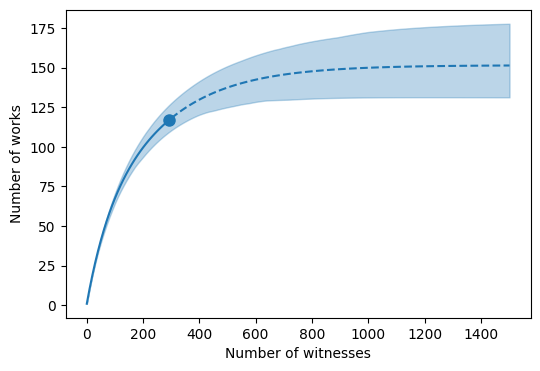

In [ ]:
import matplotlib.pyplot as plt
from copia.plot import accumulation_curve

fig, ax = plt.subplots(figsize=(6, 4))

accumulation_curve(
    ds_works_and_docs, accumulation, ax=ax, xlabel="Number of witnesses", ylabel="Number of works");

In the figure above, the plotted curve illustrates the state of our observed (empirical) data and the prediction of how our data would look if we continued observations.

The large blue dot represents the empirical species richness. We already know what it is from our `AbundanceData`. Do you remember what it was? If not, we can look at our `ds_works_and_docs` again:

In [ ]:
print("AbundanceData: ", ds_works_and_docs)

observed_species = ds_works_and_docs.S_obs
print("Number of observed species: ", observed_species)

observations = ds_works_and_docs.n
print("Number of observations:", observations)

AbundanceData:  AbundanceData(S_obs=117, f1=44, f2=28, n=np.int64(294), counts=array([9, 8, 8, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1]))
Number of observed species:  117
Number of observations: 294


So you can see that the blue dot representing the empirical species richness is placed at the intersection of $S_{obs}$ (117) and $n$ (294).


In the plot, we see:
- a solid line on the left, the interpolated accumulation of species with increased sampling (the rarefaction part)
- a dashed line on the right, which is a projection into the future, showing the anticipated discovery of new species or works with further document sampling (the extrapolation part).



Notably, the curve begins to flatten around 1000 documents, suggesting that beyond this point, no new unseen works are expected to be found according to the estimator.

If you don't want to approximate this number from the curve, you can examine the data. We will save it to a file, which you will be able to open in any plain text editor.

In [ ]:
accumulation.to_csv("accumulation_output.csv", sep="\t", index=True)

To examine this file, go to the left-hand side of the Colab window, click on the folder icon, and you will see there a folder called `sample_data` as well as a single file `accumulation_output.csv`. You can see that we hit an etimated 149 at iteration 911, 150 at iteration 1031, and 151 at 1301.

## 2.3 Minimum Additional Sample Size, or Estimating the Number of Documents

*This part of the tutorial is based on the Forgotten Books notebook (https://github.com/mikekestemont/forgotten-books), revised to work with the new version of Copia.*

Now, having been able to predict and visualise how the number of works would grow if we were able to keep on discovering text witnesses, we can turn to another important method included in the `Copia` package: the `minsample` method.


The function `min_add_sample` from `Copia` estimators is a lower-bound estimate of how much more sampling effort would be needed to detect the full diversity of a population, including currently unseen species (i.e. $f_0$) at least once.

As input, this function takes the `AbundanceData` object and as output it gives an apporximation of the number of individuals that would have to be sampled to see each unseen species at least once.

We can call the `diversity` function with the `minsample` method to see the estimate for the number of witnesses (documents):

In [ ]:
minsample_estimate_rounded = round(diversity(ds_works_and_docs, method='minsample'))

print('Estimated "original" number of documents:', minsample_estimate_rounded)


Estimated "original" number of documents: 1739


So we would need to have 1738 sightings (documents / witnesses) in total to observe all the works (including the 'lost' ones) at least once.


But here again, just like with `chao1`, the `minsample` method also provides an interval, which can be displayed by setting the `CI` parameter to `True`.

We will start by running it with just 100 iterations to speed things up. If you have time later, you can change the value of `n_iter` to 10000 to get more accurate numbers.

In [ ]:
minsample_interval = diversity(ds_works_and_docs, method='minsample', CI=True, n_iter=100, n_jobs=1)
print(minsample_interval)

  0%|          | 0/100 [00:00<?, ?it/s]

est    1738.835045
lci    1166.940969
uci    2697.690250
Name: 0, dtype: float64


So after 100 iterations, we see that our estimate of around 1738 (our run `est` = 1738.8350), has the confidence interval between around 1081 and 3002.

*Note that your numbers can differ significantly here in terms of total values as we run it on 100 iterations, but your `est` should be close to ours, regardless of the number of iterations.*

__What does this mean?__


- 1738 is ou point estimate — the single best guess.

- [1081, 3002] is our uncertainty range, derived from the empirical distribution of estimates under resampling.


This means that, based on your observed data (and the variability in resampled datasets used for bootstrapping), we estimate the minimum sample size at about 1739.

We are fairly certain that the actual number of documents needed to observe the lost works lies somewhere between 1081 and 3002, but __this range is quite large__.  


The confidence interval ranges from 1,081 to 3,002. This means the lower bound is roughly 38% less than the estimate, and the upper bound is about 73% higher than the estimate.

The estimate can be imprecise due to various factors:

- small sample size,
- high heterogeneity,
- or high numbers of rare, or unobserved species.


So, although 1,739 is our best estimate, the possible values could vary by -38% to +73%, which is important to keep in mind when interpreting the results. Do not treat 1738 as precise, but rather as the centre point of a much wider plausible interval.

[Note: The results you should get after changing the parameter to 10000 are around: `est`: 1738, `lci` 1015, and `uci` 2877, so better but still quite wide]

We can visualise this on our accumulation curve, where you will see that the curve is pretty flat within this interval, indicating that no new species are being observed. The dashed grey lines represent the lower and upper values of the interval (`lci` and  `uci`), and the solid grey line represents our point estimate.

  0%|          | 0/1000 [00:00<?, ?it/s]

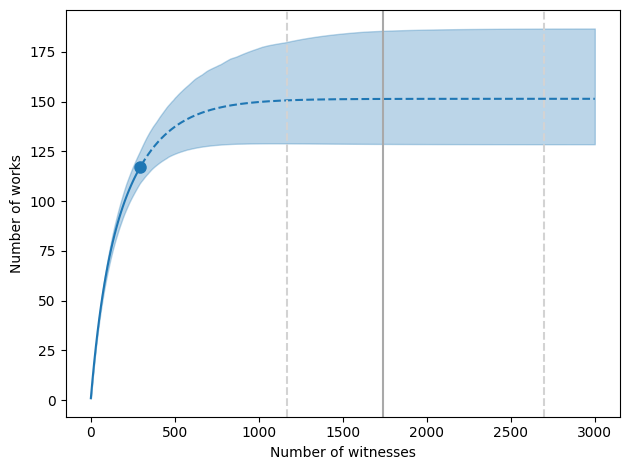

In [ ]:
accumulation = species_accumulation(ds_works_and_docs, max_steps=3000, n_iter=1000, step_size=10)
ax = accumulation_curve(
    ds_works_and_docs, accumulation, xlabel="Number of witnesses", ylabel="Number of works")
ax.axvline(minsample_interval['est'], c='darkgrey');
ax.axvline(minsample_interval['lci'], c='lightgrey', ls='--');
ax.axvline(minsample_interval['uci'], c='lightgrey', ls='--');
plt.tight_layout()

## 3. Survival Rates

Now when we have the estimates of the species richness (including the unobserved species, so the lost works, $f_0$) and the number of observations needed to observe all unseen species, so the total number of witnesses we'd need to discover, we can simply calculate the survival rates for works and documents.

### 3.1 Survival Rates (Works)

If we are happy with using our rounded estimates, we can now quickly calculate the survival rate for our medieval works.
We simply divide the number of observed (S_obs) species by the estimated number.

You can do it by hand: 117 (observed species) / 151 (estimated species richness) = 0.77

But let's do it with a short piece of code:

In [ ]:
observed_species = ds_works_and_docs.S_obs
print("Number of observed species (works): ", observed_species)

chao1_estimate_rounded = diversity(ds_works_and_docs, method='chao1')
print("Estimated species richness, so the 'original' number of works:", chao1_estimate_rounded)

survival_ratio = observed_species / chao1_estimate_rounded
print("Simple survival ratio (works):", round(survival_ratio, 3))

Number of observed species (works):  117
Estimated species richness, so the 'original' number of works: 151.45383867832848
Simple survival ratio (works): 0.773


### _Voila! We have the estimate for the survival ratio of works (77%)_

The end of the story? It can be, if you want!

But we can add some nuance by using the confidence intervals.

In the function below, for the purpose of this exercise, we will set `n_iter` to 100. In your actual future experiments, you want to run it with 10000 iterations to minimise the variation in the `lci` and `uci`.

In [ ]:
chao1_interval_ice = diversity(ds_works_and_docs, method='chao1', CI=True, n_iter=100, n_jobs=1)
surv_works_mins_ice = ds_works_and_docs.S_obs / chao1_interval_ice
print(surv_works_mins_ice)

  0%|          | 0/100 [00:00<?, ?it/s]

est    0.772513
lci    0.886338
uci    0.673419
Name: 0, dtype: float64


Let's store these calculations in a new `dataFrame`, which we will use to visualise the confidence intervals.

In [ ]:
surv = pd.DataFrame()
surv['Icelandic'] = surv_works_mins_ice
surv.index = ['est', 'uci', 'lci']
print(surv)

     Icelandic
est   0.772513
uci   0.886338
lci   0.673419


Below, we create a plot showing the confidence intervals, alongside our point estimate.

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


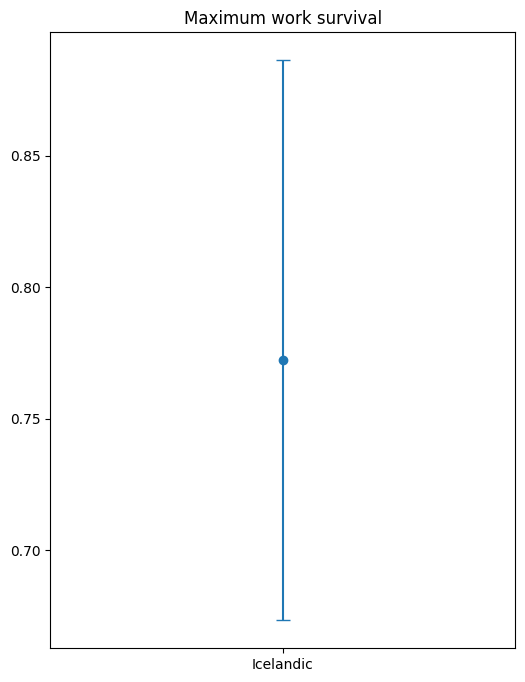

In [ ]:
main_values = surv.loc['est']
upper_ci = surv.loc['uci']
lower_ci = surv.loc['lci']
errors = [main_values - lower_ci, upper_ci - main_values]
fig, ax = plt.subplots(figsize=(6, 8))
ax.errorbar(range(len(surv.columns)), main_values, yerr=errors, fmt='o', capsize=5)
plt.xticks(range(len(surv.columns)), surv.columns)
plt.title("Maximum work survival");

### 3.2 Exercise: Survival Rates (Documents)

Using the same logic, we can now simply calculate the survival rate for documents by dividing the number of documents in our dataset by the estimated number of observations, so 294 / 1738 = 0.17.

Now it's your turn to code. Using the examples above, can you now calculate the confidence intervals and produce the error bars for the loss of witnesses, instead of works?

*Tip: You won't be using chao-1 with intervals set to true, but another method. Do you remember which one?*

In [ ]:
# Type your code here

## 3.3 Visual Comparison

Now you know how to calculate the intervals, and how to visualise them for both works and documents. A single line for Icelandic looks a bit sad, doesn't it?

Let's compare it with something.

Let's try to compare the survival of works in Dutch and French. We will used the published 'Forgotten Books' dataset that can be found here: https://github.com/mikekestemont/forgotten-books/tree/main/datasets/master


In [ ]:
# Dutch
url = 'https://raw.githubusercontent.com//mikekestemont/forgotten-books/main/datasets/master/dutch.xlsx'
df_dutch = pd.read_excel(url, engine='openpyxl')
df_dutch.columns = 'work', 'signature', 'repository'
ds_dutch = to_copia_dataset(df_dutch, data_type="abundance", input_type="observations", index_column="work")
chao1_interval_dutch = diversity(ds_dutch, method='chao1', CI=True, n_iter=100, n_jobs=1)
surv_works_mins_dutch = ds_dutch.S_obs / chao1_interval_dutch
print(surv_works_mins_dutch)

  0%|          | 0/100 [00:00<?, ?it/s]

est    0.492067
lci    0.685518
uci    0.323859
Name: 0, dtype: float64


In [ ]:
# French
url = 'https://raw.githubusercontent.com//mikekestemont/forgotten-books/main/datasets/master/french.xlsx'
df_french = pd.read_excel(url, engine='openpyxl')
df_french.columns = 'work', 'signature', 'repository'
ds_french = to_copia_dataset(df_french, data_type="abundance", input_type="observations", index_column="work")
chao1_interval_french = diversity(ds_french, method='chao1', CI=True, n_iter=100, n_jobs=1)
surv_works_mins_french = ds_french.S_obs / chao1_interval_french
print(surv_works_mins_french)

  0%|          | 0/100 [00:00<?, ?it/s]

est    0.535293
lci    0.627834
uci    0.433611
Name: 0, dtype: float64


In [ ]:
surv = pd.DataFrame()
surv['Icelandic'] = surv_works_mins_ice
surv['French'] = surv_works_mins_french
surv['Dutch'] = surv_works_mins_dutch
surv.index = ['est', 'uci', 'lci']
print(surv)

     Icelandic    French     Dutch
est   0.772513  0.535293  0.492067
uci   0.886338  0.627834  0.685518
lci   0.673419  0.433611  0.323859


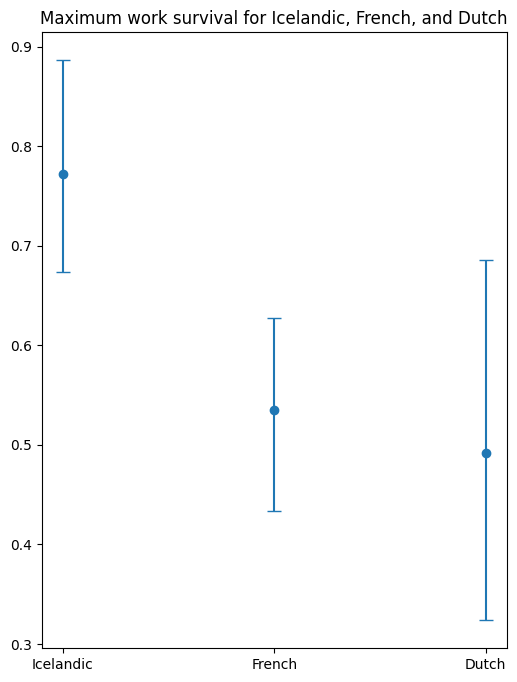

In [ ]:
main_values = surv.loc['est']
upper_ci = surv.loc['uci']
lower_ci = surv.loc['lci']

errors = [main_values - lower_ci, upper_ci - main_values]

fig, ax = plt.subplots(figsize=(6, 8))
ax.errorbar(range(len(surv.columns)), main_values, yerr=errors, fmt='o', capsize=5)
plt.xticks(range(len(surv.columns)), surv.columns)
plt.title('Maximum work survival for Icelandic, French, and Dutch');

The visualisation makes it easy to illustrate not only the differences in the point estimates for each corpus (the blue dot), but also the confidence intervals for each tradition.
It looks like the French interval is a bit smaller than the Dutch and the Icelandic. Perhaps due to the differences in the size of the corpus, or its structure. Let examine each dataset.

Which difference do you see?



In [ ]:
Icelandic_obs = ds_works_and_docs.S_obs
Icelandic_n = ds_works_and_docs.n
Icelandic_f1 = ds_works_and_docs.f1
Icelandic_f2 = ds_works_and_docs.f2

French_obs = ds_french.S_obs
French_n = ds_french.n
French_f1 = ds_french.f1
French_f2 = ds_french.f2

Dutch_obs = ds_dutch.S_obs
Dutch_n = ds_dutch.n
Dutch_f1 = ds_dutch.f1
Dutch_f2 = ds_dutch.f2



print('Icelandic:', Icelandic_obs, Icelandic_n, Icelandic_f1, Icelandic_f2)
print('French:', French_obs, French_n, French_f1, French_f2)
print('Dutch:', Dutch_obs, Dutch_n, Dutch_f1, Dutch_f2)

Icelandic: 117 294 44 28
French: 222 1473 90 21
Dutch: 75 167 45 13


Yes, you are right that the proportions between the number of texts seen only once and twice is quite different. Not surprising, as this is the fundamental features measured by the `chao1` method.

## 4. Exercise: Witness or Library Item

You might have noticed that in the texts of this notebook we sometimes refer to documents, sometimes to witnesses.

This is not because we are being inconsistent. Rather, it is meant to prompt a question about how we count things:
- Do we count shelfmarks of extant manuscripts?
- Do we count sigla of witnesses (textual attestations of works, which can be divided into multiple codices)?

We did the latter, but should we?

Consider, for example, the well-known *rímur* manuscript *Staðarhóltsbók rímna*. It is so important that it even has a stub article on the Icelandic Wikipedia: https://is.wikipedia.org/wiki/Sta%C3%B0arh%C3%B3lsb%C3%B3k_r%C3%ADmna. This volume –- a single medieval book –- is today divided into multiple booklets, and some of its texts (witnesses of *rímur*) are split between two booklets. An example is the Staðarhóltsbók witness of _Reinalds rímur_ (a set of riddararímur from the 15th century) which is split between AM 604 a 4to and AM 604 b 4to.

How should we count texts like _Reinalds rímur_, which are split between two library items today but clearly represent the same medieval witness?


In [ ]:
# Rimur MS
import pandas as pd

# Define the URL where is your file with raw data in xlsx format
url = 'https://raw.githubusercontent.com/KAKDH/UnseenSpeciesCopia-/main/data/ridd_rimur_ms.xlsx'

# Read the Excel file (specify the engine just in case)
df_mss = pd.read_excel(url, engine='openpyxl')
df_mss.columns = 'work', 'work_date', 'signature', 'repository', 'wit_date'

ds_mss = to_copia_dataset(
   df_mss, data_type="abundance", input_type="observations", index_column="work")
print(ds_mss)

AbundanceData(S_obs=24, f1=11, f2=6, n=np.int64(45), counts=array([4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1]))


In [ ]:
url = 'https://raw.githubusercontent.com/KAKDH/UnseenSpeciesCopia-/main/data/ridd_rimur_wit.xlsx'
df_wit = pd.read_excel(url, engine='openpyxl')
df_wit.columns = 'work', 'work_date', 'signature', 'repository', 'wit_date'

ds_wit = to_copia_dataset(
   df_wit, data_type="abundance", input_type="observations", index_column="work")
print(ds_wit)

AbundanceData(S_obs=24, f1=11, f2=7, n=np.int64(44), counts=array([4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1]))


In [ ]:
chao1_interval_mss = diversity(ds_mss, method='chao1', CI=True, n_iter=10000, n_jobs=1)
print(chao1_interval_mss)


  0%|          | 0/10000 [00:00<?, ?it/s]

est    33.859259
lci    21.216723
uci    62.827834
Name: 0, dtype: float64


In [ ]:
chao1_interval_wit = diversity(ds_mss, method='chao1', CI=True, n_iter=10000, n_jobs=1)
print(chao1_interval_wit)

  0%|          | 0/10000 [00:00<?, ?it/s]

est    33.859259
lci    21.708844
uci    62.587733
Name: 0, dtype: float64
